In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

from os import listdir
from os.path import isfile, join

from rapidfuzz import process

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
%config InlineBackend.figure_format="retina"

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

# 1 - Dataset Creation

In [3]:
datasets = {}

path = "data/"
for f in listdir(path):
    if isfile(join(path, f)):
        datasets[f.replace(".csv", "")] = pd.read_csv(join(path, f))

print(datasets.keys())

dict_keys(['game_lineups', 'stats', 'Soccer_Football Clubs Ranking', 'players', 'club_games', 'clubs'])


player_valuations: Les joueurs ont leur prix évalués chaque année, 2 fois, dans le dataset.

Hors, la dernière année comporte qu'une valeur. Cette valeur correspond a celle du dataset players.csv

On peut donc se passer de player_valuations.

In [4]:
# Clear columns
clear_columns = {
    "players": {
        "first_name",
        "last_name",
        "player_code",
        "city_of_birth",
        "country_of_citizenship",
        "image_url",
        "url"
    },

    "stats": {
        "Rk", "Born", 
    }
}

# Clear too old data, we keep 2023 ones.
# The issue is that, we have valuations for each year. Something we don't want.

# Some names are in double in stats.csv, keep the newer


Players et stats sont 2 datasets fusionnés
Ce qu'on peut extraire des autres csv est le ratio de victoires ( club_games ), combien de fois le joueur a été capitaine, si il était remplaçant ou titulaire ( game_lineups ),  

In [5]:
lups = datasets["game_lineups"]
all_players = lups['player_id'].unique()

# captains
team_captain_games = lups[lups['team_captain'] == 1]
captain_counts = team_captain_games['player_id'].value_counts()
captain_counts = captain_counts.reindex(all_players, fill_value=0)

# starting
starting_lineups = lups[lups['type'] == "starting_lineup"]
starting_counts = starting_lineups['player_id'].value_counts()
starting_counts = starting_counts.reindex(all_players, fill_value=0)

# substitutes
substitutes = lups[lups['type'] == "substitutes"]
substitutes_counts = substitutes['player_id'].value_counts()
substitutes_counts = substitutes_counts.reindex(all_players, fill_value=0)

# Rename
substitutes_counts.columns = ['player_id', 'substitutes_number']
starting_counts.columns = ['player_id', 'starting_lineup_number']
captain_counts.columns = ['player_id', 'captain_number']

starting_counts = starting_counts.reset_index()
substitutes_counts = substitutes_counts.reset_index()
captain_counts = captain_counts.reset_index()

# Merge the clean_dataset with counts DataFrames
_datasetCleaning = pd.merge(datasets["stats"], datasets["players"], on="name")
_datasetCleaning = pd.merge(_datasetCleaning, substitutes_counts, on="player_id", how="left")
_datasetCleaning = pd.merge(_datasetCleaning, starting_counts, on="player_id", how="left")
_datasetCleaning = pd.merge(_datasetCleaning, captain_counts, on="player_id", how="left")

In [6]:
print(_datasetCleaning.shape)

(1933, 149)


...

### Converting squad column into club ranking

Since the squad column is a categorical value with many possible outcomes, performing one-hot encoding on it would produce a big amount of columns (one for each team).

We know there should be a correlation between the club a player belongs to and a player's market value. Since good teams usually have good players, so more valuable ones. Therefore, we would like to keep some information about the team. 

In order to solve this problem, we use another dataset in which we have several football teams and their latest rankings, and we try to replace the club names with their rankings.

The first problem we encounter is that the clubs in our original dataset might be refered to with slightly different names than in the new dataset we're trying to use, since we got it from a different source, for example, 'Machester United' could be referred to as 'Man United'.

To resolve this, we use fuzzy matching to find, for each player’s club, the closest matching club name in the rankings dataset. Once the matches are established, we replace the club names in the original dataset with their corresponding rankings. This method works because the club names in both datasets are very similar and differ only by minor variations, such as spelling or abbreviations.

First, we notice that all the players we have in the original dataset play in the top five leagues, therefore we restrict the rankings dataset to teams from five countries (England, Spain, Germany, Italy and France). This is especially useful because some teams have the same name. For example, 'Real Sociedad' is both present in Spain and Uruguay. But we make sure that there are no teams with the same name from the rankings dataset in these five countries. This way we make sure the matching is done correctly.

In [7]:
# Players outside of the top 5 leagues in our dataset
s = 0
leagues = _datasetCleaning.iloc[:, -5:]
indexes = []
for i, row in leagues.iterrows():
    add = False
    for j in range(5):
        if row[j] == True:
            add = True
    if not add:
        s += 1
        indexes.append(i)
s

1504

Since there are no players out of the top five leagues, we can proceed with restricting the rankings dataset on the five countries mentioned previously. 

In [8]:
rankings_df = pd.read_csv(path + 'Soccer_Football Clubs Ranking.csv', sep=';')

# We only keep teams in the big 5 leagues
rankings_df = rankings_df[rankings_df['country'].isin(['Germany', 'Spain', 'France', 'Italy', 'England'])]
rankings_df.head()

,ranking,club name,country,point score,1 year change,previous point scored,symbol change
0,88,1. FC Köln,Germany,1633,105,1545,+
1,74,1. FC Union Berlin,Germany,1655,5,1654,+
20,11,AC Milan,Italy,1850,21,1741,+
54,270,AFC Bournemouth,England,1512,7,1512,-
70,823,Ajaccio,France,1369,13,1369,-


We check for duplicates in the rankings dataset.

In [9]:
# Check for duplicate teams
duplicates = rankings_df['club name '][rankings_df['club name '].duplicated()]

if not duplicates.empty:
    print(f"There are {duplicates.nunique()} unique duplicate values and {duplicates.size} total duplicates in the column 'club name '.")
    print("Duplicate values and their counts:")
    print(duplicates.value_counts())
else:
    print(f"There are no duplicates in the column 'club name '.")

There are 6 unique duplicate values and 6 total duplicates in the column 'club name '.
Duplicate values and their counts:
club name 
Angers           1
Evian TG         1
GFC Ajaccio      1
Málaga           1
Middlesbrough    1
Nancy            1
Name: count, dtype: int64


In [10]:
duplicate_rows = rankings_df[rankings_df['club name '].duplicated(keep=False)]
duplicate_rows

,ranking,club name,country,point score,1 year change,previous point scored,symbol change
223,475,Angers,France,1440,121,1474,-
224,475,Angers,France,1440,121,1474,-
913,484,Evian TG,France,1439,2,1439,-
914,484,Evian TG,France,1439,2,1439,-
1165,485,GFC Ajaccio,France,1438,1,1438,-
1166,485,GFC Ajaccio,France,1438,1,1438,-
1628,451,Málaga,Spain,1446,1,1446,-
1629,451,Málaga,Spain,1446,1,1446,-
1691,465,Middlesbrough,England,1443,4,1443,-
1692,465,Middlesbrough,England,1443,4,1443,-


We notice that the rows don't refer to different teams, so we can delete the duplicates.

In [11]:
# Remove duplicate rows based on the column 'club name '
rankings_df = rankings_df.drop_duplicates(subset='club name ', keep='first')
duplicates = rankings_df['club name '][rankings_df['club name '].duplicated()]

if not duplicates.empty:
    print(f"There are {duplicates.nunique()} unique duplicate values and {duplicates.size} total duplicates in the column 'club name '.")
    print("Duplicate values and their counts:")
    print(duplicates.value_counts())
else:
    print(f"There are no duplicates in the column 'club name '.")

There are no duplicates in the column 'club name '.


Now, we can proceed with our matching:

In [12]:
# Create a dictionary of matches
club_list = rankings_df['club name '].tolist()
club_rankings = rankings_df.set_index('club name ')['ranking'].to_dict()

def get_best_match(club_name):
    match, score, _ = process.extractOne(club_name, club_list)
    if score >= 50:  # Adjust threshold as needed
        return club_rankings[match]
    return None

# Apply the function to all rows using pandas' `apply`
_datasetCleaning['Squad'] = _datasetCleaning['Squad'].apply(get_best_match)
_datasetCleaning.rename(columns={'Squad': 'Club Ranking'}, inplace=True)


The football clubs are replaced with their corresponding rankings. We can proceed with the data cleaning.

# 2 - Data Cleaning

### 2.1 - One-Hot encoding/String transform

In [13]:
_datasetCleaning["foot"] = [int(x == "right") for x in _datasetCleaning["foot"]]
_datasetCleaning = pd.concat([_datasetCleaning, pd.get_dummies(_datasetCleaning.sub_position)], axis=1)
_datasetCleaning = pd.concat([_datasetCleaning, pd.get_dummies(_datasetCleaning.Comp)], axis=1)

### 2.2 - Converting Columns to Numericals

We convert boolean columns to 0s and 1s.

In [14]:
bool_columns = _datasetCleaning.select_dtypes(include=['bool']).columns
for col in bool_columns:
    _datasetCleaning[col] = _datasetCleaning[col].astype(int)

print("Boolean columns converted to 0s and 1s.")

Boolean columns converted to 0s and 1s.


We drop non-numeric columns we don't need from our dataset.

In [15]:
# Identify non-numeric columns in the dataset
post_process_drops = [
    "Rk", "name", "Nation", "first_name", "last_name", "player_code", "city_of_birth", "date_of_birth", "contract_expiration_date", "agent_name", "image_url", 
    'current_club_domestic_competition_id', "url",
    "country_of_birth", "country_of_citizenship", # 102 unique values
    "sub_position", "position", "Comp", # one-hot encoding
    "current_club_name", # 198 unique values
    "Pos", # Doublon
    "Born" # The year in which a player is equivalent the age so we remove it
]

_datasetCleaning = _datasetCleaning.drop(post_process_drops, axis=1, errors='ignore')

We check if there are any non-numeric variables left.

In [16]:
# Check for non-numeric columns
non_numeric_columns = _datasetCleaning.select_dtypes(exclude=['number'])
if not non_numeric_columns.empty:
    print("Non-numeric columns and their types:")
    for col in non_numeric_columns.columns:
        print(f"{col}: {non_numeric_columns[col].dtype}")
else:
    print("No non-numeric columns found.")

No non-numeric columns found.


### 2.3 - Null values

We remove columns having only null values (if they exist), and each row containing a null value.

In [17]:
# Cleaning null values
columnsSizePreNA = _datasetCleaning.shape[1]
_datasetCleaning.dropna(how='all', axis=1, inplace=True) # We remove useless columns
print("We removed " + str(columnsSizePreNA - _datasetCleaning.shape[1]) + " columns.")

columnsSizePreNA = _datasetCleaning.shape[0]
_datasetCleaning.dropna(how='any', axis=0, inplace=True) # We remove null values
print("We removed " + str(columnsSizePreNA - _datasetCleaning.shape[0]) + " rows.")

We removed 0 columns.
We removed 372 rows.


# 3 - Exploratory Data Analysis and Further Data Cleaning

### 3.1 - Correlations Between Independent Variables

We check for pairs of independent variables that are highly correlated.

In [18]:
correlations = _datasetCleaning.corr()
np.fill_diagonal(correlations.values, np.nan)
high_corr_pairs = {}
corr_dict = correlations.to_dict()
d_columns = list(corr_dict.keys())

for i in range(len(d_columns)):
    for j in range(i + 1, len(d_columns)):
        corr_value = corr_dict[d_columns[i]][d_columns[j]] 
        if abs(corr_value) > 0.9:
            high_corr_pairs[(d_columns[i], d_columns[j])] = corr_value

if high_corr_pairs:
    print("Highly correlated feature pairs:")
    for pair, corr_value in high_corr_pairs.items():
        print(f"{pair}: {corr_value:.2f}")
else:
    print("No highly correlated feature pairs found.")

Highly correlated feature pairs:
('MP', 'Min'): 0.90
('MP', '90s'): 0.90
('Starts', 'Min'): 0.99
('Starts', '90s'): 0.99
('Min', '90s'): 1.00
('PasTotCmp', 'PasTotAtt'): 0.97
('PasTotCmp', 'PasTotDist'): 0.94
('PasTotCmp', 'PasAtt'): 0.97
('PasTotCmp', 'PasLive'): 0.97
('PasTotCmp', 'PasCmp'): 1.00
('PasTotCmp', 'Touches'): 0.93
('PasTotCmp', 'TouLive'): 0.93
('PasTotAtt', 'PasTotDist'): 0.92
('PasTotAtt', 'PasAtt'): 1.00
('PasTotAtt', 'PasLive'): 0.98
('PasTotAtt', 'PasCmp'): 0.97
('PasTotAtt', 'Touches'): 0.97
('PasTotAtt', 'TouLive'): 0.97
('PasTotDist', 'PasMedCmp'): 0.93
('PasTotDist', 'PasMedAtt'): 0.91
('PasTotDist', 'PasAtt'): 0.92
('PasTotDist', 'PasLive'): 0.91
('PasTotDist', 'PasCmp'): 0.94
('PasShoCmp', 'PasShoAtt'): 0.99
('PasMedCmp', 'PasMedAtt'): 0.98
('PasAtt', 'PasLive'): 0.98
('PasAtt', 'PasCmp'): 0.97
('PasAtt', 'Touches'): 0.97
('PasAtt', 'TouLive'): 0.97
('PasLive', 'PasCmp'): 0.97
('PasLive', 'Touches'): 0.96
('PasLive', 'TouLive'): 0.96
('PasLive', 'Carries'): 0.

In [19]:
for i in _datasetCleaning:
    print(i)

Club Ranking
Age
MP
Starts
Min
90s
Goals
Shots
SoT
SoT%
G/Sh
G/SoT
ShoDist
ShoFK
ShoPK
PKatt
PasTotCmp
PasTotAtt
PasTotCmp%
PasTotDist
PasTotPrgDist
PasShoCmp
PasShoAtt
PasShoCmp%
PasMedCmp
PasMedAtt
PasMedCmp%
PasLonCmp
PasLonAtt
PasLonCmp%
Assists
PasAss
Pas3rd
PPA
CrsPA
PasProg
PasAtt
PasLive
PasDead
PasFK
TB
Sw
PasCrs
TI
CK
CkIn
CkOut
CkStr
PasCmp
PasOff
PasBlocks
SCA
ScaPassLive
ScaPassDead
ScaDrib
ScaSh
ScaFld
ScaDef
GCA
GcaPassLive
GcaPassDead
GcaDrib
GcaSh
GcaFld
GcaDef
Tkl
TklWon
TklDef3rd
TklMid3rd
TklAtt3rd
TklDri
TklDriAtt
TklDri%
TklDriPast
Blocks
BlkSh
BlkPass
Int
Tkl+Int
Clr
Err
Touches
TouDefPen
TouDef3rd
TouMid3rd
TouAtt3rd
TouAttPen
TouLive
ToAtt
ToSuc
ToSuc%
ToTkl
ToTkl%
Carries
CarTotDist
CarPrgDist
CarProg
Car3rd
CPA
CarMis
CarDis
Rec
RecProg
CrdY
CrdR
2CrdY
Fls
Fld
Off
Crs
TklW
PKwon
PKcon
OG
Recov
AerWon
AerLost
AerWon%
player_id
last_season
current_club_id
foot
height_in_cm
market_value_in_eur
highest_market_value_in_eur
count_x
count_y
count
Attacking Midfield


We notice that some pairs of independent variables have very high correlation, so there is multicollinearity. Some of them reaching one in absolute value, which means some features might carry redundant information. For example 'Min' represents the number of minutes played by a player. and '90s' represents how many 90 minutes were played (matches), and the two are linked by the following relationship $\text{90s} = \frac{\text{Min}}{90}$. 

So by keeping the two variables we store some redudant information. This can negatively impact certain machine learning models, especially linear models or those sensitive to feature scaling and relationships (e.g., Logistic Regression, Linear Regression) where coefficients become unreliable due to the inability to distinguish the impact of correlated variables. 

Therefore, we proceed by removing some of the independent variable that have high correlations. We focus on the ones that have the most high correlations, for example 'PasTotAtt' has very high correlations with six other independent variables, so we remove it.

Based on the correlation values, we identify the following columns to remove: "Starts", "90s", "Rec", "PasTotCmp", "PasTotAtt", "PasTotDist", "PasShoCmp", "PasMedCmp", "PasAtt", "PasLive", "PasCrs", "TklW", "Touches".

In [20]:
post_process_drops = [
    "Starts", "90s", "Rec", "PasTotCmp", "PasTotAtt", "PasTotDist", "PasShoCmp", "PasMedCmp", "PasAtt", "PasLive", "PasCrs", "TklW", "Touches"
]

_datasetCleaning = _datasetCleaning.drop(post_process_drops, axis=1, errors='ignore')

### 3.2 - Correlations With the Target Variable and Data Visualisation

We compute the correlations with the target variable, and we check for the highest correlations in absolute value.

In [21]:
# Computing highest correlations with the target variable
target = 'market_value_in_eur' 
correlations = _datasetCleaning.corr()
corr_dict = correlations.to_dict()
d_columns = list(corr_dict.keys())
high_corr = {}

for i in corr_dict[target]:
    if abs(corr_dict[target][i]) > 0.25:
        high_corr[i] = corr_dict[target][i]

high_corr

{'Club Ranking': -0.25505438177067746,
 'MP': 0.2824128960862085,
 'Min': 0.31683511806825526,
 'Goals': 0.4261720984659066,
 'market_value_in_eur': 1.0,
 'highest_market_value_in_eur': 0.7944839259130252,
 'count_y': 0.38939433950481317,
 'Premier League': 0.27804906619317143}

- 'Club Ranking': The correlation is negative because higher club rankings (closer to 1, so better teams) are associated with more valuable players. However, this does not mean that every player belonging to a top team has a high market value. For example, substitutes are usually not as good as the players in the starting eleven. As a result, the negative correlation between club ranking and market value exists but is not very strong in absolute value.

- 'Min': The correlation is positive, as players with more minutes on the field are more likely to be skilled and stand out, leading to higher market value. However, this is not always the case. In lower-ranked teams, less valuable players often get more minutes due to a lack of better options. Additionally, some highly valuable players in top teams might spend more time on the bench, and injuries can also reduce minutes for valuable players. Therefore, while there is a positive correlation, it is not very high.

- 'Goals': There is a positive correlation, and it is one of the highest among features. Players who score the most goals usually have higher market values. However, this correlation may vary for players in smaller teams who get more minutes and score goals, their overall market value might still depend on other stats or skills and especially on the league they're playing in.

- 'highest_market_value_in_eur': High correlation with the target variable, this is due to the fact that many players might currently have their highest market value.

- 'count_y': ...

- 'Premier League': There is a positive correlation. Over recent years, market values for players in the Premier League have tended to be higher compared to players in other leagues. This is due to factors like the Premier League’s intensity and competitiveness, the influence of the English press and PR, and the league’s financial capacity. Players with similar skills in other leagues might be evaluated differently because of these factors.

Next, we make scatterplots of some of the variables that are highly correlated with the dependent variable:

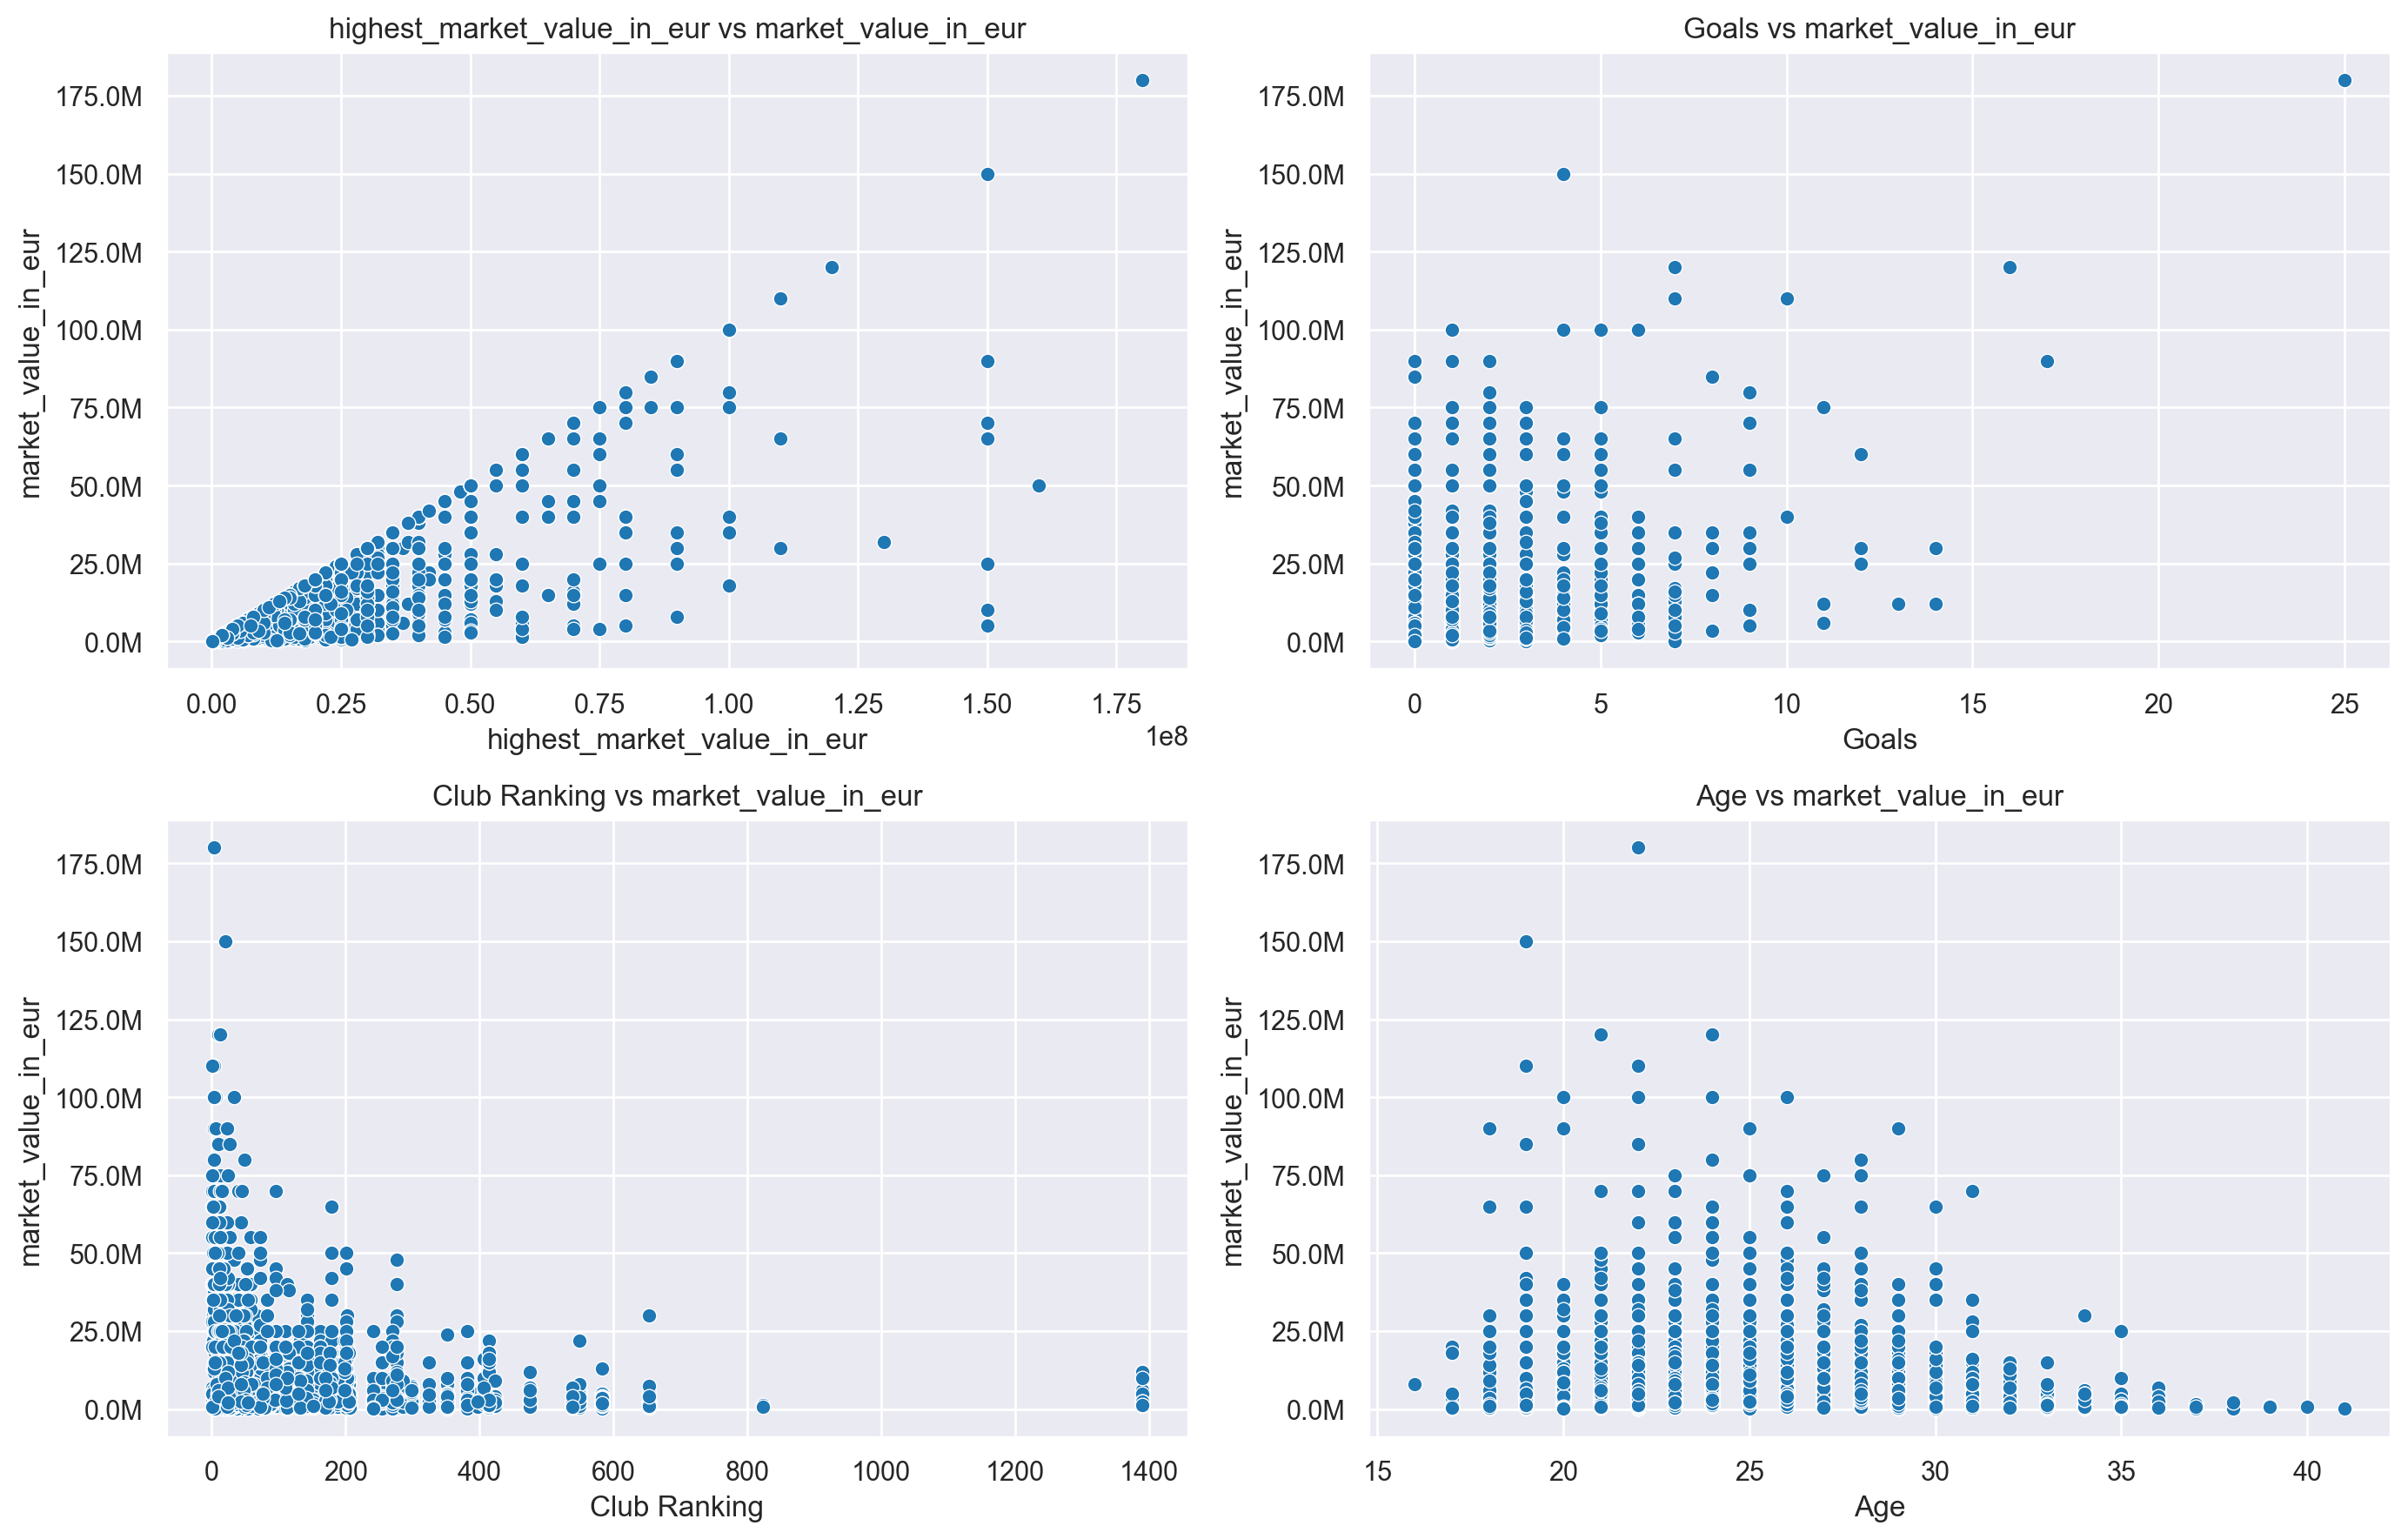

In [22]:
selected_variables = ['highest_market_value_in_eur', 'Goals', 'Club Ranking', 'Age']  # Replace with your chosen variables
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M' 

plt.figure(figsize=(14, 9))

for i, var in enumerate(selected_variables):
    plt.subplot(2, 2, i + 1) 
    sns.scatterplot(_datasetCleaning, x=selected_variables[i], y=target)
    plt.title(f"{var} vs {target}")
    plt.xlabel(var)
    plt.ylabel(target)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.tight_layout()
plt.show()

- 'highest_market_value_in_eur' : We notice a linear relationship with the target variable. As we mentioned before, this is due to the fact that many players market value is historically their highest, and often a player's market value is not very far from its highest. Exceptions to this occur when a player is very old, or their performances have consistently declined over a long period.

- 'Goals': Most of the goal values are concentrated in the interval $[0, 5]$. Within this range, the market value is spread, indicating that scoring few goals does not always imply a specific market value. As the number of goals gets higher we tend to see higher market values.

- 'Club Ranking': As discussed earlier, we generally observe higher market values for players in top teams (those with lower ranking numbers). However, there is a high density of players with lower market values playing for teams ranked in the top 200. Additionally, we observe some outliers in teams ranked extremely low (below 1000). These outliers are removed from the analysis to avoid distortion of results.

- 'Age': The scatterplot displays a clear non linear pattern with a peak around a specific age range (likely in the early to mid 20s). This reflects players in their prime, when their physical abilities, experience, and skill sets are at their peak. Players aged below 23 generally have lower market values, with a few exceptions (likely exceptional talents or players with high potential). Young players are still developing their skills and gaining experience, which limits their immediate market value. Older players are perceived as having less long-term potential and reduced physical capabilities, leading to a sharp decline in market value. Some experienced top players may still retain relatively high market values, but they are very rare exceptions.

In [23]:
_datasetCleaning = _datasetCleaning[_datasetCleaning['Club Ranking'] < 1000]

For 'Premier League', which is a categorical variable (binary), we plot the two boxplots showing the market value (dependent variables) for players in the Premier League and players in the other four leagues.

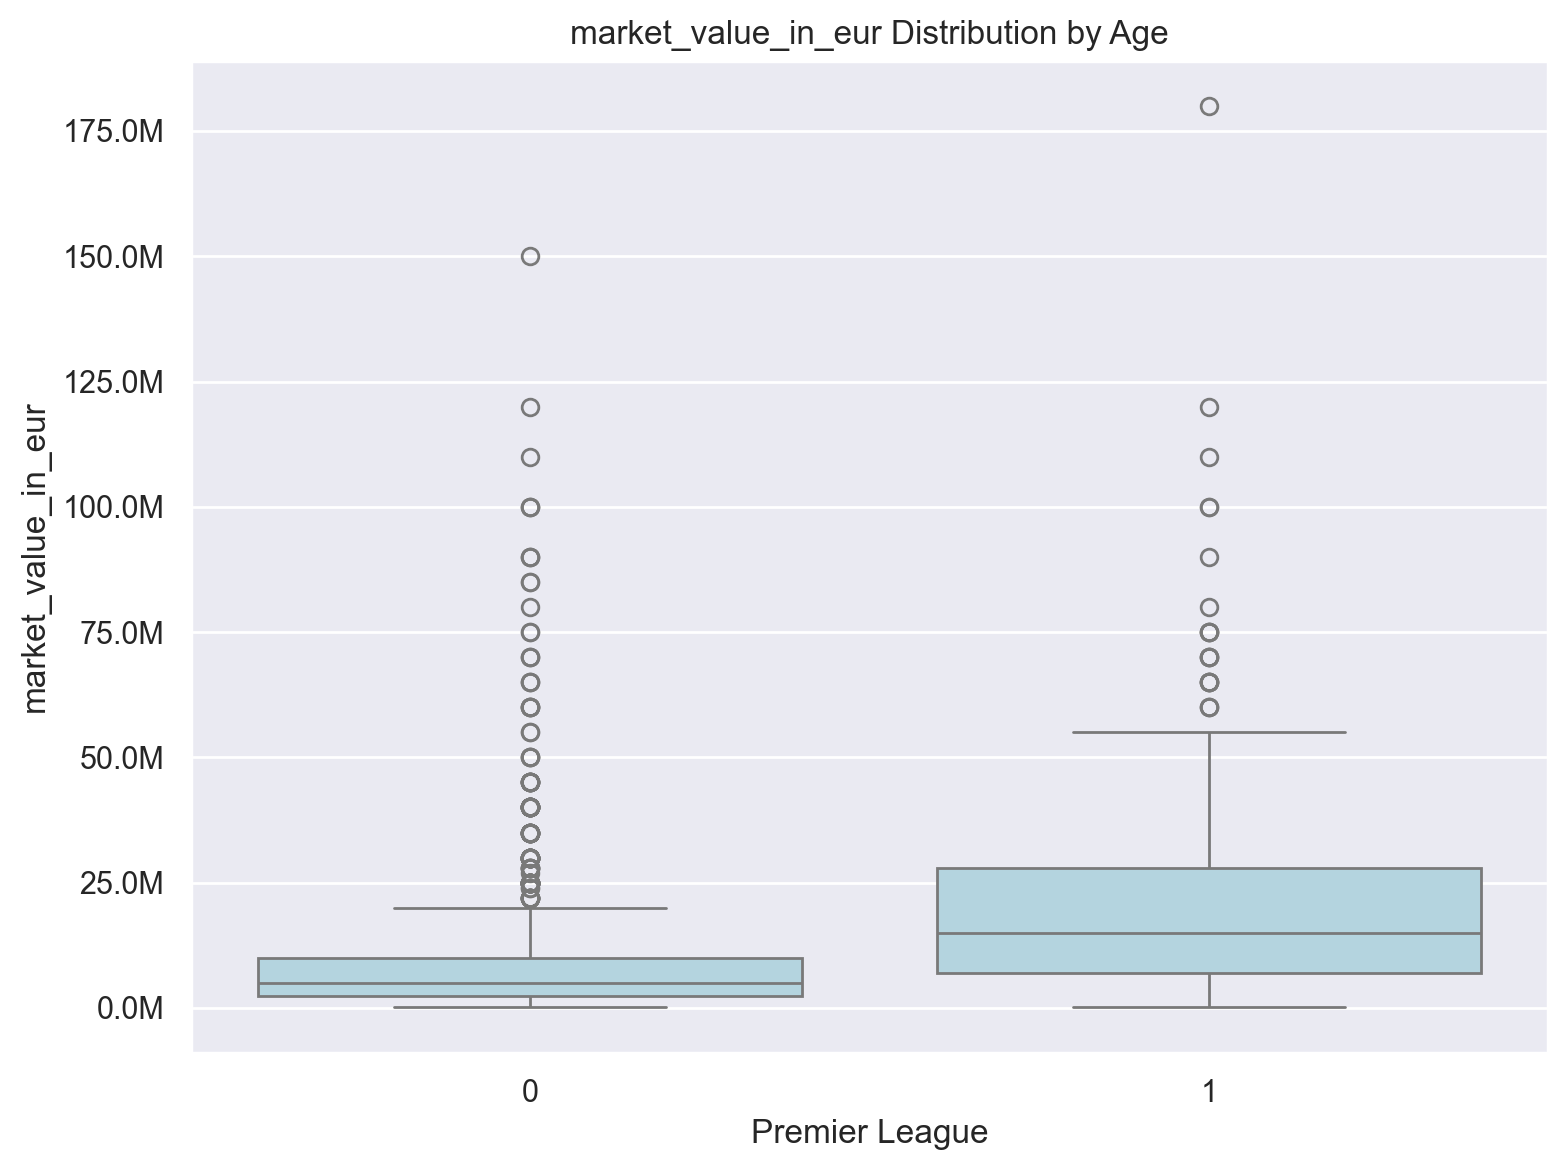

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=_datasetCleaning['Premier League'], y=_datasetCleaning[target], color='lightblue')
plt.title(f"{target} Distribution by Age")
plt.xlabel('Premier League')
plt.ylabel(target)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

We observe that the median and, in particular, the 75th percentile of market value are significantly higher for players in the Premier League. This supports our earlier argument that players in the Premier League tend to achieve higher market values on average.

### 3.3 - Feature transformation

By looking at the scatterplot of 'market_value_in_eur' vs 'Club Ranking', we notice a non linear relationship between the two variables.
We denote the dependent variable as $y$ (market value) and the independent variable as $x$ (‘Club Ranking’), the relationship between the two can be approximated as $y \propto \frac{1}{x}$, with the points being densly concentrated under the curve $y = \frac{1}{x}$. Furthermore, we notice that as the rankings approach 1 (top teams), the density of players with very high market values is not as high, and we still have a lot of players with low market value. Therefore, we can refine the approximation of the relationship and say that $y \propto \frac{1}{\sqrt[4]{x}}$, with the points densely concentrated under this curve.

Based on these findings, and in order to exploit this relationship, we apply a feature transformation to the variable $x$ (Club Ranking) by creating a new feature $f(x) = \frac{1}{\sqrt[4]{x}}$. This reciprocal fourth root feature mapping, is performed to capture the observed non-linear relationship between $x$ and the target variable $y$ (Market Value). The original variable $x$ is mapped to a new space where the relationship with $y$ becomes more linear and better aligns with the dense distribution of points under the curve $y = \frac{1}{\sqrt[4]{x}}$. This process is an example of feature mapping, which transforms features to enhance their relevance and improve the model’s ability to learn meaningful patterns. We call this new variable 'club_trans'.

In [25]:
_datasetCleaning['club_trans'] = 1/np.power(_datasetCleaning['Club Ranking'], (1/4))
_datasetCleaning.head()

,Club Ranking,Age,MP,Min,Goals,Shots,SoT,SoT%,G/Sh,G/SoT,...,Right Midfield,Right Winger,Right-Back,Second Striker,Bundesliga,La Liga,Ligue 1,Premier League,Serie A,club_trans
0,162,22,20,1596,1,1.53,0.28,18.5,0.04,0.20,...,0,0,0,0,0,0,0,1,0,0.280299
1,203,35,22,1980,0,0.86,0.05,5.3,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0.264927
3,199,22,20,1799,1,0.60,0.15,25.0,0.08,0.33,...,0,0,0,0,0,0,1,0,0,0.266248
4,382,30,15,1165,0,0.31,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0.226196
5,79,26,1,11,0,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0.335423


We show a scatterplot of the new variable vs market value.

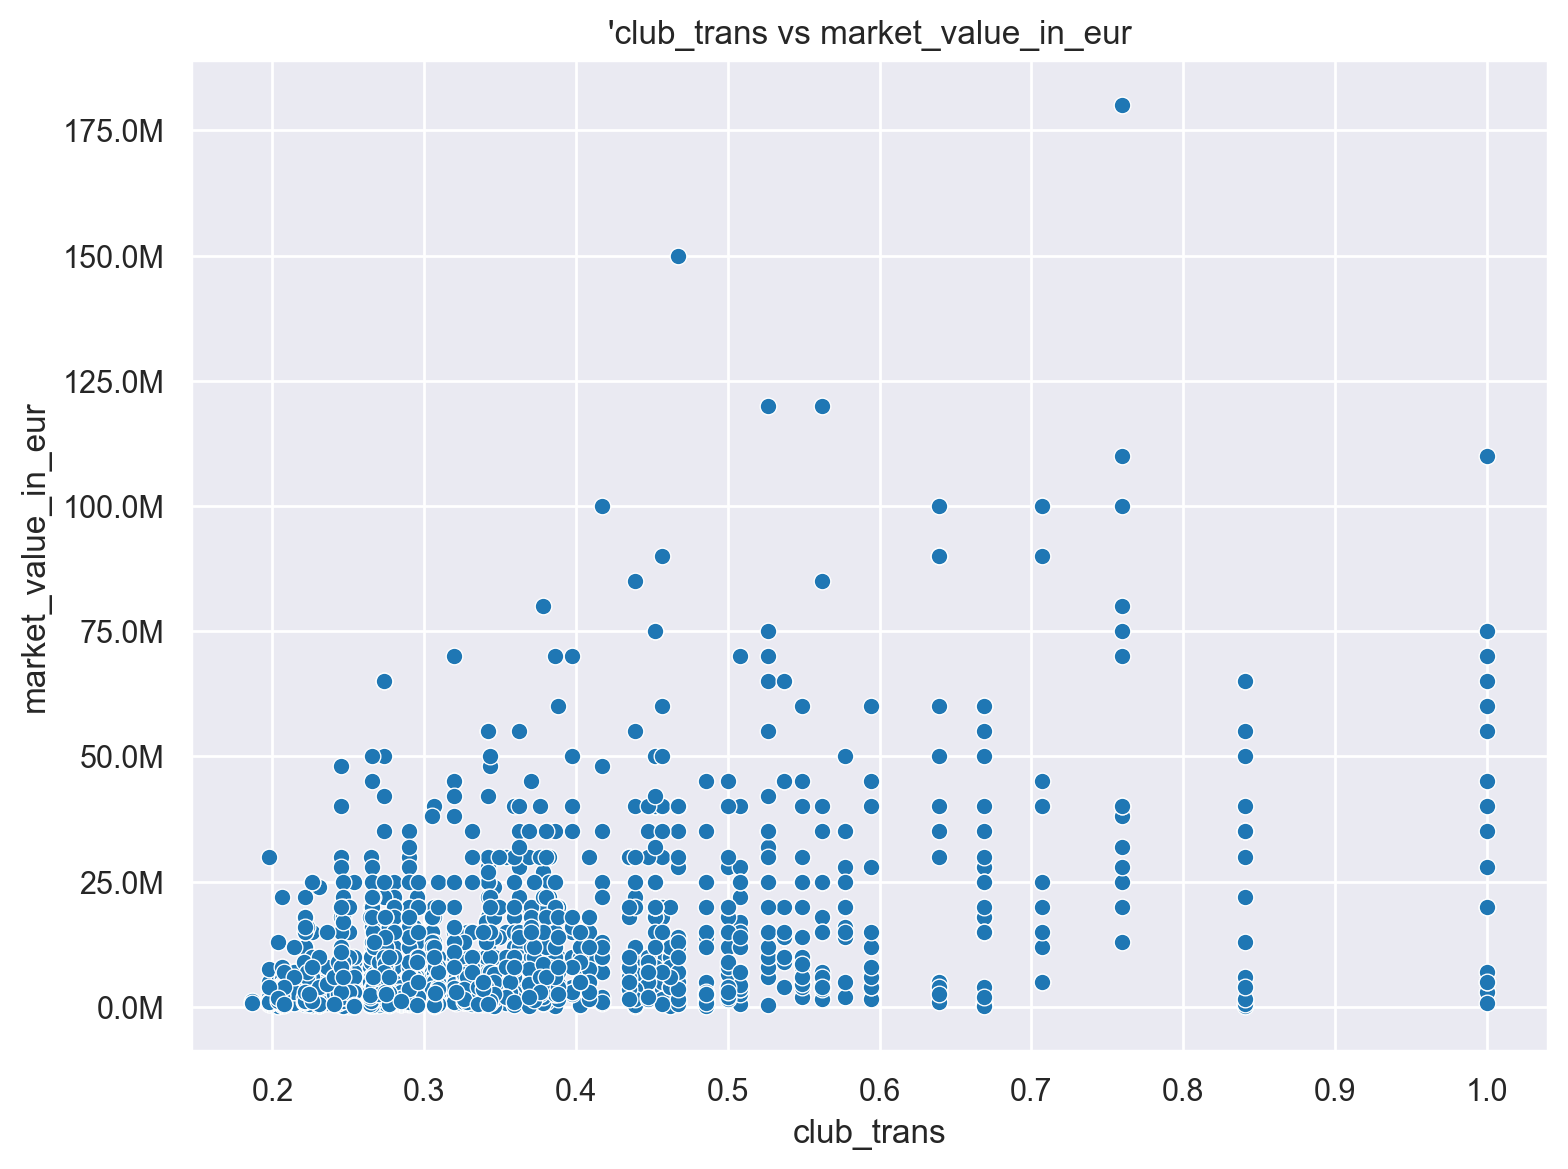

In [26]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.scatterplot(data=_datasetCleaning, x='club_trans', y=target)
plt.title(f"'club_trans vs {target}")
plt.xlabel('club_trans')
plt.ylabel(target)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

Correlation of the new feature with the target:

In [27]:
_datasetCleaning['club_trans'].corr(_datasetCleaning[target])

np.float64(0.46250567902514483)

We observe that the relationship between the new variable and the target is more linear. Additionally, the correlation between the two is one of the highest, indicating that the transformation was effective in improving the relationship and capturing the underlying pattern.

# 4 - Train-Test Split

In [28]:
X = _datasetCleaning.drop(target, axis=1)
Y = _datasetCleaning[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# 5 - Model Selection

In [29]:
models = {
    "Linear Regression": (LinearRegression(), {"model__fit_intercept": [True, False]}),
    "Ridge Regression": (Ridge(), {"model__alpha": [0.1, 1.0, 10.0]}),
    "Lasso Regression": (Lasso(), {"model__alpha": [0.01, 0.1, 1.0]}),
    "ElasticNet": (ElasticNet(), {"model__alpha": [0.01, 0.1, 1.0], "model__l1_ratio": [0.3, 0.5, 0.7]}),
    "Decision Tree": (DecisionTreeRegressor(), {"model__max_depth": [3, 5, 10], "model__min_samples_split": [2, 5, 10]}),
    "Random Forest": (RandomForestRegressor(random_state=42), {"model__n_estimators": [50, 100, 200], "model__max_depth": [3, 5, 10]}),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), {"model__n_estimators": [50, 100, 200], "model__learning_rate": [0.01, 0.1, 0.2], "model__max_depth": [3, 5]})
}

# Dictionary to store results
results = {}

best_model_name = None
best_model = None
best_score = float('inf')

for name, (model, params) in models.items():
    print(f"Training {name}...")
    
    # Create the pipeline with standard scaler and the model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    # Perform GridSearchCV
    grid = GridSearchCV(
        pipeline, 
        param_grid=params, 
        cv=5, 
        scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'}, 
        refit='MSE',  
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model_current = grid.best_estimator_
    best_cv_mse = -grid.cv_results_['mean_test_MSE'][grid.best_index_] 
    best_cv_r2 = grid.cv_results_['mean_test_R2'][grid.best_index_]    
    
    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "Best CV Score (MSE)": best_cv_mse,
        "Best CV Score (R^2)": best_cv_r2,
        "Best Model": best_model_current
    }

    if best_cv_mse < best_score:
        best_score = best_cv_mse
        best_model_name = name
        best_model = best_model_current

# Print summary of results
for name, res in results.items():
    print(f"\n{name}")
    print(f"Best Params: {res['Best Params']}")
    print(f"Best CV Score (MSE): {res['Best CV Score (MSE)']:.2f}")
    print(f"Best CV Score (R^2): {res['Best CV Score (R^2)']:.4f}")

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e+16, tolerance: 2.588e+13
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.541e+16, tolerance: 2.418e+13
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Training ElasticNet...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.682e+16, tolerance: 2.588e+13
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+16, tolerance: 2.711e+13
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...

Linear Regression
Best Params: {'model__fit_intercept': True}
Best CV Score (MSE): 92573188822444.67
Best CV Score (R^2): 0.6834

Ridge Regression
Best Params: {'model__alpha': 10.0}
Best CV Score (MSE): 80829029146787.50
Best CV Score (R^2): 0.7201

Lasso Regression
Best Params: {'model__alpha': 1.0}
Best CV Score (MSE): 82871427904129.06
Best CV Score (R^2): 0.7121

ElasticNet
Best Params: {'model__alpha': 0.1, 'model__l1_ratio': 0.7}
Best CV Score (MSE): 80345884620308.12
Best CV Score (R^2): 0.7219

Decision Tree
Best Params: {'model__max_depth': 10, 'model__min_samples_split': 2}
Best CV Score (MSE): 69377472454937.42
Best CV Score (R^2): 0.7507

Random Forest
Best Params: {'model__max_depth': 10, 'model__n_estimators': 200}
Best CV Score (MSE): 52329229692738.98
Best CV Score (R^2): 0.8307

Gradient Boosting
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 10

The best performing model is Gradient Boosting, with the lowest mean square error with a substantial gap from other models, and with the highst R squared value.

# 6 - Prediction on the Test Set

We use the best model we got to predict the test set.

In [30]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=42))])

In [31]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test Score MSE: {mse:.0f}")
print(f"Test Score MAE: {mae:.0f}")
print(f"Test Score R^2: {r2:.4f}")

Test Score MSE: 40686682560541
Test Score MAE: 3519089
Test Score R^2: 0.8588


We notice that the performance of our model on the test set is almost the same as in the validation set, which means our model generalizes very well on unseen data and doesn't overfit on the training set.

The Mean Absolute Error gives us an idea of the error made on average by our model in predicting the market value. This error is pretty low considering that the market value can get up to 200M for some players.